<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/crnn/CRNN_Final_Exps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Config

In [3]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation"
classes = ["english","mandarin","india"]

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation/raw_10s_3classes_npy"

aug = True

if aug:
    train_set_folders = []

else:
    train_set_folders = []

model_checkpoints_abs_path = "/content/drive/My Drive/APS360 Group Project/model_checkpoints"

## Imports and Colab Mount

In [4]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display
import os
import cv2

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Utility Function Definitions

train_data_components = []
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.ImageFolder(root=os.path.join(folder_path), transform=data_transform))
  train_data = ConcatDataset(train_data_components)

In [9]:
# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  raw_train_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "train"), loader=numpy_loader,extensions='.npy',transform=data_transform)
  val_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "validation"), loader=numpy_loader,extensions='.npy',transform=data_transform)

  train_data_components = [raw_train_data]
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.DatasetFolder(root=folder_path, loader=numpy_loader,extensions='.npy',transform=data_transform))
  train_data = ConcatDataset(train_data_components)
  return raw_train_data, val_data, []

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'india']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0][0])
    plt.colorbar()

    print("Array shape is", array.shape)
    return array.shape
    
# train utils 

def get_accuracy_rnn(model, data_loader):
    correct = 0
    total = 0
    for array, labels in data_loader:
        if torch.cuda.is_available():
          array = array.cuda()
          labels = labels.cuda()
        input_array = array.float().cuda().transpose(1,2)
        out = model(input_array) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input_array.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy_cnn(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda().float()
          labels = labels.cuda()
        out = model(imgs) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

## Data Gen

Array shape is (27, 1, 13, 431)
13


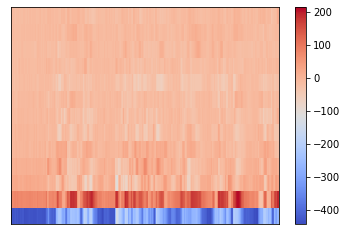

In [7]:
train_data, val_data, []= generate_data_numpy()
(batch_size, dummy, mfcc_bands, length) = visualize_numpy_data(train_data)
print(mfcc_bands)

In [8]:
from collections import Counter

print(dict(Counter(train_data.targets)))
train_data.classes

{0: 126, 1: 162, 2: 184}


['english', 'india', 'mandarin']

## Train Func

In [10]:
def train_crnn_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    best_val_acc = 0 
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.float().cuda()
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_cnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

        if epoch>30 and val_acc[-1]>best_val_acc:
            print("SAVED MODEL")
            model_name = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
            checkpoint_subdir_path = get_model_name(net.name, batch_size, learning_rate, str(epoch+1))
            full_checkpoint_path = os.path.join(model_checkpoints_abs_path, checkpoint_subdir_path)
            try:
                torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
            except FileNotFoundError:
                os.makedirs(full_checkpoint_path)
                torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
        if val_acc[-1]>best_val_acc:
            best_val_acc = val_acc[-1]
        if n % 10 == 0:
            plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

## Experiments

### CRNN:

27 Batch, epoch 40, lr 0.001, 
dataset: raw_3classes_20bands_10s_npy_CRNN, conv 32, 64, fc 25,12 hidden size 50, batch 27


In [11]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 25),
                                nn.Linear(25,12),
                            nn.Linear(12, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output